In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import re
import matplotlib.pyplot as plot
import seaborn as sns

CSCI 3022
Final Project

Chloe H. Pickering


Project Topic:

I am interested in tackling the classification problem of predicting gender from names. Given a name, the model will predict whether the name is masculine or feminine. Although it may seem that this problem is not multivariate, a name string must be broken down into several factors, such as length (integer), presence or absence of certain letters (binary), syllable structures (categorical), syllable count (integer), and vowel letters as a proportion of total letters (float). This is a nice binary classification task, because naturally the data is split approximately half-and-half between the two classes, although some names occur as both masculine and feminine. The critical task is choosing which name features should go into the model, and the key insight that improved the accuracy of my model was the use of n-gram name encoding, which I will explain below.

This is an interesting topic, since certainly some factors will be more relevant to the classfication than others, and understanding which factors are important under which conditions would tell us something about how names are gendered. The degree of success in training the model could also tell us how much of gendered associations with names are simply learnt one-by-one, or whether there are systematic patterns which allow us to gender novel names. For example, many feminine names derived from Romance languages end in an '-a' suffix.


Data:

I found my principal data set 'Gender by Name' on the UCI Machine Learning Repository, published by Arun Rao at UC Berkeley. (https://archive.ics.uci.edu/ml/datasets/Gender+by+Name#) The data set is sourced from four baby name registries in English-speaking countries:

1. US: Baby Names from Social Security Card Applications - National Data, 1880 to 2019 
2. UK: Baby names in England and Wales Statistical bulletins, 2011 to 2018 
3. Canada: British Columbia 100 Years of Popular Baby names, 1918 to 2018 
4. Australia: Popular Baby Names, Attorney-General's Department, 1944 to 2019

It is packaged as a .csv file 'name_gender_dataset.csv', with 147269 entries with four attributes: name, gender, count, and probability.

In [22]:
name_data = pd.read_csv('name_gender_dataset.csv')
name_data

,Name,Gender,Count,Probability
0,James,M,5304407,1.451679e-02
1,John,M,5260831,1.439753e-02
2,Robert,M,4970386,1.360266e-02
3,Michael,M,4579950,1.253414e-02
4,William,M,4226608,1.156713e-02
...,...,...,...,...
147264,Zylenn,M,1,2.736740e-09
147265,Zymeon,M,1,2.736740e-09
147266,Zyndel,M,1,2.736740e-09
147267,Zyshan,M,1,2.736740e-09


The name attribute is categorical and has data type String, and the gender attribute is binary categorical but also has data type String. Every entry is marked as either 'M' or 'F'. However, alongside the basic letters of English in upper and lower case, the name data also includes some instances of punctuation, numbers, and foreign characters. Further, the count attribute is of data type numeric/integer and indicates how many times a name-gender pair is recorded, and the probability attribute is the same statistic normalized by the total number of observations, represented as a float.

Data Citation: Rao, A. (2020). _Gender by Name_ [Data set]. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Gender+by+Name#

Data Cleaning:

As noted above, the data is relatively clean as-given, except for the 'Name' category. Every entry is marked as either 'M' or 'F', and is associated with a sensible-looking count and probability. Recalculating the probabilities, we find the sum of the absolute differences of the new and given probability is fairly small, although not insignificant. This is probably due to floating point issues, and it is important to keep in mind the dangers of dealing with very small floating point probabilities. It will likely be more useful to deal with the integer counts.

In [3]:
print(np.unique(name_data["Gender"]))

total_sum = np.sum(name_data["Count"])
prob_check = name_data["Count"] / total_sum
np.sum(abs(prob_check - name_data["Probability"]))

['F' 'M']


4.6895329668295707e-07

The 'Name' category requires more attention. The 26 letters of standard English, capital and lower case, make up the vast majority of characters in the data. Generally, the first letter of the name is capital, while the rest are lower case. Some names have multiple capital letters, usually indicating important breaks in the name like for two-word names or apostrophed names. Because there are no all-caps names except for initials, the number of capital letters is an indicator for the number of separate words in a name. It will likely be a better indicator than the more intuitive indicator, spaces, because spaces do not occur in the data.

In addition, there are a number of names containing special characters. These actually appear to be encoding errors, strangely nearly always originally being an 'e'. It would be possible to make this assumption and change the letters, and then consolidate their counts with the already existing much larger, correctly-spelled entries, but because the counts on these names are neglible, we will elect to elide them entirely.

There are an interesting group of names containing '@' symbols, all of Indian origin. The '@' appears to mark a word boundary. Among the rest of the punctuation, the only characters which appear to not be formatting mistakes are the dash, apostrophe, and period. There are only a few dozen names containing characters other than the standard 26 letters, dash, apostrophe, period and at symbol, and instead of expending effort and introducing error by trying to forensically reconstruct the names, it is best to elide them. 

At first I thought the '@' symbol might be an interesting feature to play with, since it can be used to easily pull out a group of Indian names. However, the ~100 names with this symbol pale in comparison to the ~150,000 without, and so it would certainly be a not especially useful feature in a classification model.

In [23]:

letter_set = reduce(lambda x, y: set(x).union(set(y)), name_data["Name"])
sorted_letters = list(letter_set)
sorted_letters.sort()
print('Unique Letters: ' + str(sorted_letters))

all_caps_names = [name for name in name_data["Name"] if not re.search(r'[a-z]+', name)]
print('All caps names: ' + str(all_caps_names))

special_char_names = [name for name in name_data["Name"] if re.search(r'[¡àöœ…]+', name)]
print('Special character names: ' + str(special_char_names))

at_char_names = [name for name in name_data["Name"] if re.search(r'[@]+', name)]
print('@ character names: ' + str(at_char_names))

strange_names = [name for name in name_data["Name"] if re.search(r'[^A-Za-z-\'@.]+', name)]
print('Other names: ' + str(strange_names))

clean_data = name_data[name_data['Name'].str.contains("^[A-Za-z.'-]+(@[A-Za-z.'-]+)?$")]
clean_data['Name'] = clean_data['Name'].str.replace('@', '')
filtered_data = clean_data[clean_data["Name"] != "TRUE"]


Unique Letters: ['"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '5', '7', '8', '9', ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', 'à', 'ö', 'œ', '…']
All caps names: ['TRUE', 'TRUE', 'L…O', 'T…A', 'P', 'Y', 'M', 'B', 'I', 'J', 'A', 'A', 'A.J.', 'G', 'J.', 'S', 'B.', 'D', 'K', 'K.', 'O', 'P.', 'R', 'W/O', 'A.', 'C', 'D', 'F', 'H.', 'J.B.', 'K', 'M.', 'M.N.', 'N.', 'P.', 'S/O', 'T.J', 'T.J.', 'V.', 'V.B.']
Special character names: ['Zoà', 'Chlo…', 'Am…Lie', 'Maàlle', 'Andr…', 'Chloà', 'Esm…', 'Ren…E', 'F…Lix', 'L…O', 'S…Bastien', 'Zo…', 'T…A', 'Dant…', 'Anaœs', 'Jos…', 'Loœc', 'Mat…O', 'Oce¡', 'Miloö']
@ character names: ['Bhagwati@Shinnu', 'Soni@', 'Sonu@Akil', 'Vivek@', 'Anjali@Rinku', 'Anno@', 'Bharati@Ruchika', 'Ekta@Mamta', 'Guddiya@Guddi',

/tmp/ipykernel_237/3767604207.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  clean_data = name_data[name_data['Name'].str.contains("^[A-Za-z.'-]+(@[A-Za-z.'-]+)?$")]
/tmp/ipykernel_237/3767604207.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['Name'] = clean_data['Name'].str.replace('@', '')


EDA:

Each entry in the data set represents a name-gender pair. For this reason, there are two entries for certain names: one for M and one for F. For each name-gender pair, there is a Count attribute which gives a raw count of how many times the name is associated with the gender. Then, the Probability attribute is simply the count integer normalized by the total size of the data, stored as a float.

For this reason, name to gender is not a simple binary classficiation problem. Each name has a likeliness of being masculine or feminine. Depending on how it is best to structure the project, we could eliminate all entries which are gender-ambiguous, delete the less likely gender entry, or retain both entries. However, more than 90% of names in the data set are exclusively gendered.

In [5]:
proportion_unisex_names = 1 - len(np.unique(clean_data["Name"])) / len(clean_data["Name"])
proportion_unisex_names

0.09076702518701718

An important fact about the data is that of the 147,268 gender-name pairs, there are many many more uncommon pairs than common ones. This log-scaled histogram shows that the vast proportion of name-gender pairs occur only a few times, while common names are outliers. It is possible that these especially common names may behave differently, since culturally we have memorized their gender associations, and wouldn't need to recover them from the form of the name. This imbalance will be something to remain aware of as we learn more about classification models.

(array([7.604e+03, 2.900e+01, 1.000e+01, 5.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

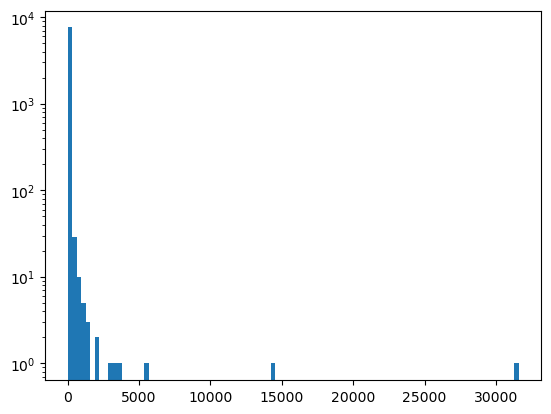

In [6]:
entries_by_count = clean_data.groupby("Count").count()["Name"]
plot.hist(entries_by_count, log = True, bins = 100)

However, luckily, the all-important gender classifications are fairly balanced. 61% of name pairs are classed feminine, while 39% are classed masculine. This is due to feminine names being more diverse than masculine names in the data set, as if these proportions are adjusted for name popularity, we see nearly 50-50 gender proportion, with actually slightly more recorded men.

In [7]:
proportion_feminine_names = (clean_data["Gender"] == 'F').sum() / len(clean_data["Gender"])
print('Feminine-classed pairs: ' + str(proportion_feminine_names))

print('\nPopulation by gender:')
clean_data.groupby("Gender")["Count"].sum()

Feminine-classed pairs: 0.6095027143818071

Population by gender:


Gender
F    180621746
M    184774790
Name: Count, dtype: int64

Understanding our data as it is, after some cleaning, let's start break the names down into features. To start with, let's add features for name length, vowel density, starting letter, ending letter, and number of capital letters.

In [24]:
augmented_data = clean_data.copy()

augmented_data["Length"] = augmented_data["Name"].apply(len)
def vowel_density(name):
    vowels = 'aeiouAEIOU'
    num_vowels = sum([1 for letter in name if letter in vowels])
    num_letters = len(name)
    return num_vowels / num_letters
augmented_data["Vowel Density"] = augmented_data["Name"].apply(vowel_density)

augmented_data["Starting Letter"] = augmented_data["Name"].str[0]
augmented_data["Ending Letter"] = augmented_data["Name"].str[-1]

augmented_data["Capital Letters"] = [sum(1 for letter in name if letter.isupper()) for name in augmented_data["Name"]]

print(augmented_data)

           Name Gender    Count   Probability  Length  Vowel Density  \
0         James      M  5304407  1.451679e-02       5       0.400000   
1          John      M  5260831  1.439753e-02       4       0.250000   
2        Robert      M  4970386  1.360266e-02       6       0.333333   
3       Michael      M  4579950  1.253414e-02       7       0.428571   
4       William      M  4226608  1.156713e-02       7       0.428571   
...         ...    ...      ...           ...     ...            ...   
147264   Zylenn      M        1  2.736740e-09       6       0.166667   
147265   Zymeon      M        1  2.736740e-09       6       0.333333   
147266   Zyndel      M        1  2.736740e-09       6       0.166667   
147267   Zyshan      M        1  2.736740e-09       6       0.166667   
147268    Zyton      M        1  2.736740e-09       5       0.200000   

       Starting Letter Ending Letter  Capital Letters  
0                    J             s                1  
1                    J 

Breaking down each name into these features makes the classification problem easier to tackle, as we can conceive of each name as the product of multiple variables. Let's examine a few:

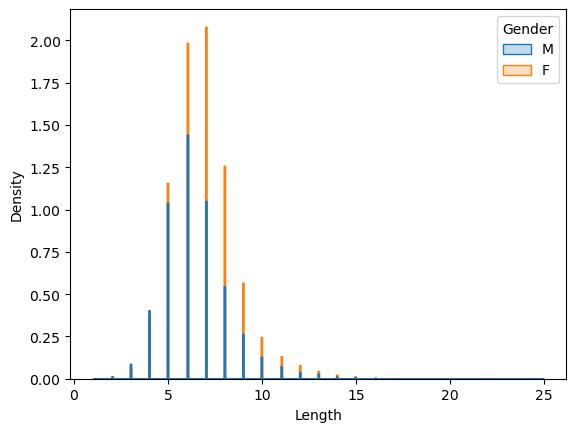

In [9]:
sns.histplot(x='Length', hue='Gender', data=augmented_data, element='step', stat='density')
plot.show()

The above is a histogram of name length, separated out by gender. At first glance, length appears to be normally distributed, with a higher mean for women than men. Both exhibit a right skew. It appears that long names could be either male or female, but short names are much more likely to be male.

We'd like to also examine first and last letter patterns:

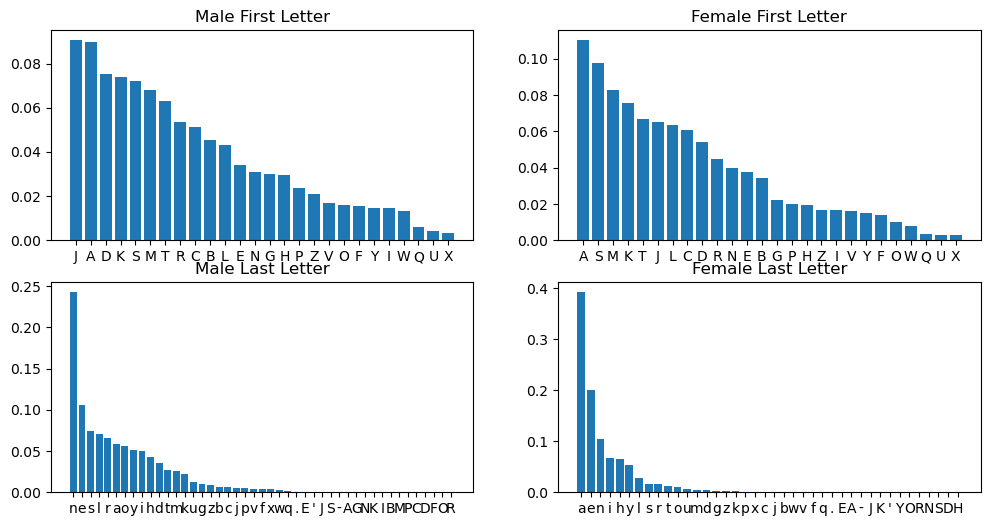

In [10]:
male_first = augmented_data[augmented_data['Gender'] == 'M']['Starting Letter'].value_counts(normalize=True)
female_first = augmented_data[augmented_data['Gender'] == 'F']['Starting Letter'].value_counts(normalize=True)
male_last = augmented_data[augmented_data['Gender'] == 'M']['Ending Letter'].value_counts(normalize=True)
female_last = augmented_data[augmented_data['Gender'] == 'F']['Ending Letter'].value_counts(normalize=True)
fig, axs = plot.subplots(2, 2, figsize= (12, 6))
axs[0, 0].bar(male_first.index, male_first.values)
axs[0, 0].set_title('Male First Letter')
axs[0, 1].bar(female_first.index, female_first.values)
axs[0, 1].set_title('Female First Letter')
axs[1, 0].bar(male_last.index, male_last.values)
axs[1, 0].set_title('Male Last Letter')
axs[1, 1].bar(female_last.index, female_last.values)
axs[1, 1].set_title('Female Last Letter')
plot.show()

These histograms are somewhat surprising. The first letter frequencies, for both male and female, decline in a nearly linear fashion, whereas the most frequent last letters make up a much higher share of the probability mass. The standout common male last letter is 'n', whereas the female counterpart is 'a'. However, both letters are common finals for either gender. We could form a hypothesis test to see whether the difference in the frequencies between the genders is statistically significant. It's important to remember that these can't be interpreted as, if the last letter is an 'a', there is a 0.4 chance the name is female, only that 40% of recorded female names have last letter 'a'. However, we remember that name usage counts are heavily right skewed, so a small number of names make up most of the names in use.

Let's examine vowel density:

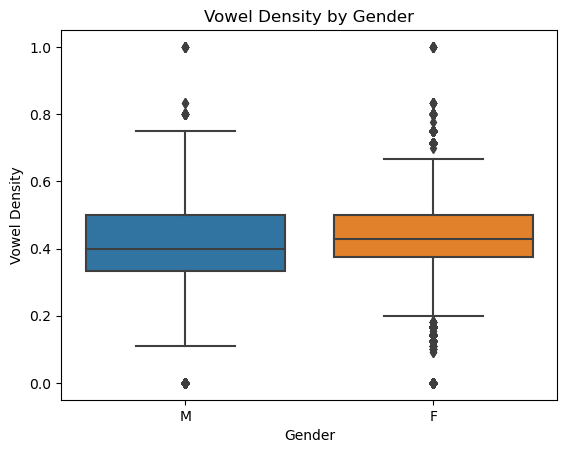

In [11]:
sns.boxplot(x='Gender', y='Vowel Density', data=augmented_data)
plot.title('Vowel Density by Gender')
plot.xlabel('Gender')
plot.ylabel('Vowel Density')
plot.show()

Not much relationship can be discerned here, which surprised me. Women's names have a slightly stronger central tendency here, but they are not all that much more vowel-heavy than men's names, at least as can be told from this diagram. I suspect this feature is not as useful as I may have thought, and it may be worth breaking this up into more 'vowel' features. 

Let's zoom out and examine our features in aggregate:

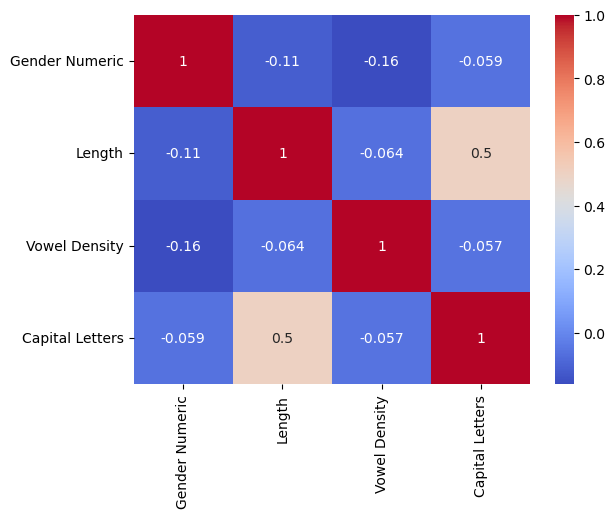

In [12]:
augmented_data["Gender Numeric"] = augmented_data["Gender"].apply(lambda g: 1 if g == "M" else 0)
corr = augmented_data[['Gender Numeric', 'Length', 'Vowel Density', 'Capital Letters']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plot.show()

We see a correlation between capital letters and length, which is not especially interesting, and we see a minor correlation between vowel density and female. This is not especially compelling, and indicates that we might try different numerical features. 

Our most interesting features so far have been first and last letter occurrences, but this is likely not enough input for this classification task. We can solve this by introducing n-grams features, a generalization of our first and last letter occurrence approach, which keeps track of all the occurrences of sequences of n letters in each name.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
name_ngrams = vectorizer.fit_transform(augmented_data['Name'])

name_ngrams

<147179x10316 sparse matrix of type '<class 'numpy.int64'>'
	with 1531197 stored elements in Compressed Sparse Row format>

This produces a very large, sparse matrix, with 147,179 rows representing each name and 10,316 columns representing the occurence of each n-gram. We choose to store occurrences of 2-grams and 3-grams, although this can be tweaked. Essentially adding 10,316 features to our model, we introduce probable over-fitting, where we have given the model enough information to essentially memorize each name. We will be cognizant of this moving forward.

Model Approach:

This is a binary prediction problem, with balanced data sizes for each class. Further, since some names occur as both male and female at different probabilities, we would like our model to express its degree of confidence in its classfication. For these reasons, we would like to implement a logistic regression model. 

The logistic regression model maps a linear combination of features onto a probability, which meshes with our task of decomposing names into various features, and assigning a confidence of gender classification, being aware of the ~9% of names which exhibit at least some gender ambiguity. Logistic regression will handle this middle threshold region better than a linear regression model. The logistic regression model also serves are larger purposes, because its results are interpretable in terms of the relationships different features have on gender likeliness. The flexibility of taking linear combinations of various features is especially useful to us, since we are not yet sure exactly what feature breakdown will yield the best results. However, it is important that we avoid including features that are highly correlated with each other. This is especially important considering our use of both 2 and 3 length n-grams, where the occurence of the n-gram 'ali' implies the presence of the n-gram 'al'. This will diminish the interpretability of our results, as we will address below.

While our data set is balanced vis-a-vis gender, both raw names and count-adjusted names, a small number of names in our data set make up the vast majority of people, and a large number of names are only noted as belonging to one person. This is a matter we will have to remain aware of, because of its challenges for modeling as well as its implications on the applicability of our results. 

Modeling:

Let's design a logistic regression model based on these features. We will use in-built tools from the sklearn package. We will also take advantage of the sparse graph structures in the scipy package to efficiently store our n-gram data.

First, we need to convert our features to numeric values, scaled properly, to give the logistic regression its best shot. The categorical input variables 'Starting Letter' and 'Ending Letter', as well as the categorical output 'Gender', are currently stored as Strings. This is undesirable, so we will us sklearn's built-in LabelEncoder object to transform them. Then, we run another sklearn built-in preprocessor, StandardScaler, to properly align the magnitudes of the transformed features.

Then, the data is split apart into input (X) and output (Y), and further split into training and test samples for evaluation. We then fit a standard logistic regression as our baseline, and print out some performance metrics.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.sparse import hstack

# encode categorical (string) variables
le = LabelEncoder()
augmented_data['Starting Letter'] = le.fit_transform(augmented_data['Starting Letter'])
augmented_data['Ending Letter'] = le.fit_transform(augmented_data['Ending Letter'])
augmented_data['Gender'] = le.fit_transform(augmented_data['Gender'])

# separate data into input vector and labels
X = augmented_data.drop(['Name', 'Gender'], axis=1)
y = augmented_data['Gender']

# scale numeric features using built-in sklearn method
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# construct input vectors with n-grams
X_combined = hstack([X_scaled, name_ngrams])

# training/test split (20% test 80% train)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# run logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# report results
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.8021
Precision: 0.7557
Recall: 0.7331
F1-score: 0.7442


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Our baseline model reports an accuracy of 0.8021, with slightly lower precision, recall, and F1-scores. This indicates that while the model does predict a great number of names accurately, there is also a large number of false positives and false negatives. This is not a good accuracy by any means, but is a solid indication that our features do encode the classification info necessary for the model. Since we essentially now have ~10,000 (sparse) n-gram features, we wonder whether this might be a matter of overfitting. We want to eliminate features which are least consequential to the model, as well as features which are highly correlated with other features.

In order to make it easier for me to experiment with the pre-processing, I am using an sklearn object Pipeline to take care of what processing is applied to which features. The main material change to the pre-processing is using OneHotEncoder to encode the starting and ending letters, rather than LabelEncoder. This is more parsimonious with how the n-grams are encoded, as OneHotEncoder splits each value of the categorical variable into its own feature. Then, essentially, starting and ending letters are encoded exactly like the n-grams: they are unigrams, plus some location information. Ideally it would be nice to encode the location information for the n-grams, but I'm not sure how to do that in a way that wouldn't balloon the already-massive feature pool.

Also, we add an L1 penalty to the logistic regression, which penalizes the sum of the magnitudes of the coefficients. This promotes a sparse model, cuts extraneous features, and thus reduces overfitting. Let's examine the resulting performance metrics.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# n-grams vectorizer that works better with columntransformer
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), lowercase=False)

# determine which transforms apply to which features
preprocessor = ColumnTransformer(
    transformers=[
        ('ngrams', vectorizer, 'Name'),
        ('num', StandardScaler(), ['Length', 'Vowel Density', 'Capital Letters']),
        ('starting', OneHotEncoder(handle_unknown = 'ignore'), ['Starting Letter']),
        ('ending', OneHotEncoder(handle_unknown = 'ignore'), ['Ending Letter'])
    ])

# split data for fitting/testing
X = augmented_data.drop(columns=["Gender"])
y = augmented_data["Gender"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train model, apply l1 penalty to reduce feature count
logreg = LogisticRegression(solver='liblinear', penalty='l1')
pipe = Pipeline([('preprocessor', preprocessor), ('classifier', logreg)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# report results
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.807990216061965
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     17874
           1       0.76      0.74      0.75     11562

    accuracy                           0.81     29436
   macro avg       0.80      0.80      0.80     29436
weighted avg       0.81      0.81      0.81     29436

Confusion Matrix:
[[15221  2653]
 [ 2999  8563]]


We achieve about the same accuracy, but we improve on recall and f1-score, by starving the classifier of some extraneous features. We notice that feminine names have a higher precision than masculine ones, likely due to feminine names being more common in our data set, and that this effect appears fairly significant. To improve classficiation going forward, it may be wise to consider fitting the model on data subsets which are gender balanced. It may be possible to leverage the name popularity field in the data set to accomplish this more efficiently. Before doing so, let's examine the model we have created and determine what can be interpreted from it.

Results and Analysis:

Remembering that the primary objective of this classification task was inference/interpretation and not prediction, lets train the model using the full dataset, and then pull apart the results.

In [16]:
# n-grams vectorizer that works better with column transformer
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), lowercase=False)

# determine which transforms apply to which features
preprocessor = ColumnTransformer(
    transformers=[
        ('ngrams', vectorizer, 'Name'),
        ('num', StandardScaler(), ['Length', 'Vowel Density', 'Capital Letters']),
        ('starting', OneHotEncoder(handle_unknown = 'ignore'), ['Starting Letter']),
        ('ending', OneHotEncoder(handle_unknown = 'ignore'), ['Ending Letter'])
    ])

# split data for fitting
X = augmented_data.drop(columns=["Gender"])
y = augmented_data["Gender"]

# train model, apply l1 penalty to reduce feature count
logreg = LogisticRegression(solver='liblinear', penalty='l1')
pipe = Pipeline([('preprocessor', preprocessor), ('classifier', logreg)])
pipe.fit(X, y)
y_pred = pipe.predict(X)

# report results
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

Accuracy: 0.823106557321357
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     89706
           1       0.78      0.76      0.77     57473

    accuracy                           0.82    147179
   macro avg       0.81      0.81      0.81    147179
weighted avg       0.82      0.82      0.82    147179

Confusion Matrix:
[[77330 12376]
 [13659 43814]]


An obvious first question is, which features/n-grams were most useful in predicting gender. Let's see which model coefficients had the greatest magnitude. There are caveats to the interpretation of these, which we will discuss below.

In [17]:
# pull feature names and consolidate
ngram_feature_names = pipe.named_steps['preprocessor'].named_transformers_['ngrams'].get_feature_names_out()
num_feature_names = ['Length', 'Vowel Density', 'Capital Letters']
starting_feature_names = pipe.named_steps['preprocessor'].named_transformers_['starting'].get_feature_names_out(['Starting Letter'])
ending_feature_names = pipe.named_steps['preprocessor'].named_transformers_['ending'].get_feature_names_out(['Ending Letter'])
feature_names = np.concatenate([ngram_feature_names, num_feature_names, starting_feature_names, ending_feature_names])

# pull coefficients and consolidate
coefs = pipe.named_steps['classifier'].coef_[0]
feature_importances = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})

# sort by coefficients with highest magnitude
feature_importances_sorted = feature_importances.reindex(feature_importances.Coefficient.abs().sort_values(ascending=False).index)

# report top n coefficients
n = 20
top_ngrams = feature_importances_sorted[feature_importances_sorted['Feature'].isin(ngram_feature_names)].head(n)
print(f"Top {n} most relevant n-grams for the classification:")
print(top_ngrams)

# report number of nonzero coefficients
nonzero_coefficients = np.count_nonzero(coefs)
print(f"There are {nonzero_coefficients} features with nonzero coefficients.")

Top 20 most relevant n-grams for the classification:
      Feature  Coefficient
5972       a-   -11.404900
6182       ah   -10.177000
459       Abd     9.239823
9891       k-     6.305605
13388     tou    -6.159077
9834      jos     6.115349
13772     uko    -6.035115
6205      ahu     5.706038
9446      iob    -5.622758
9076       i-    -5.569232
6193      ahi     5.493590
15114     zab    -5.490437
9739      jea    -5.231884
11199      nn    -5.181580
8553      goc    -5.154841
5772      Zac     5.118385
6749      bet    -5.016323
6203      ahs     4.985010
11141     niq    -4.943750
12892     sha    -4.889211
There are 3254 features with nonzero coefficients.


Here, negative coefficients indicate correlation with feminine names, and positive coefficients indicate correlation with masculine names. Most of these n-grams appear to only be associated with a few names, and are thus dead giveaways as to the gender. This seems to indicate overfitting. We also report 3,255 features with nonzero coefficients, out of ~10,000 n-grams. We are pleased with this reduction, but 3,255 is still probably too many. Let's examine the feature importance plot:

Text(0.5, 1.0, 'Feature Importances')

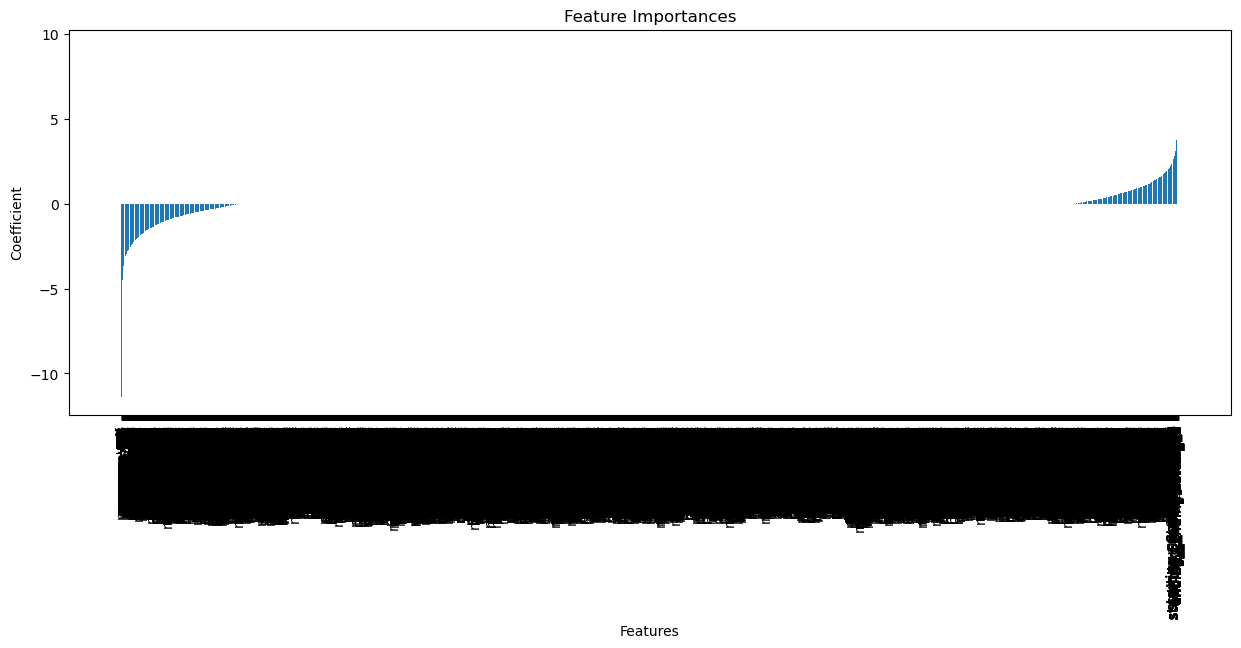

In [21]:
import matplotlib.pyplot as plt

# pull feature names and coefficients from model
feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
coef = pipe.named_steps['classifier'].coef_[0]
coef.sort()

# feature importance plot
plt.figure(figsize=(15, 5))
plt.bar(feature_names, coef)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Importances')

Of course, ~3000 features are far too many to comment individually on, but we get a sense of the distribution of feature relevance. We can see on the left n-grams which are highly associated with feminine names, and on the right n-grams which are highly associated with masculine names. 

Having had concern about precision/recall scores less than our accuracy scores earlier, possibly due to a minor mismatch in the data sizes for each class, let's create an ROC plot and a precision-recall plot.

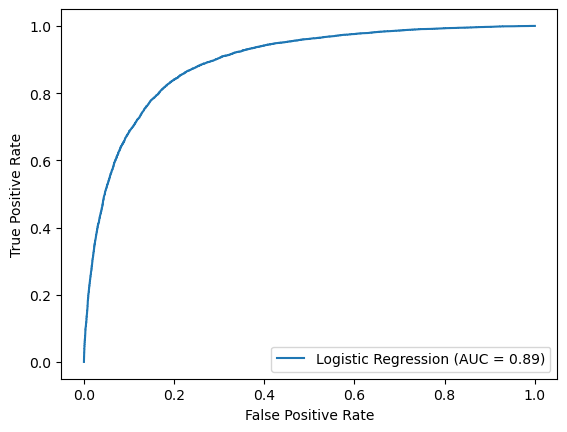

In [19]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
roc_display.plot()


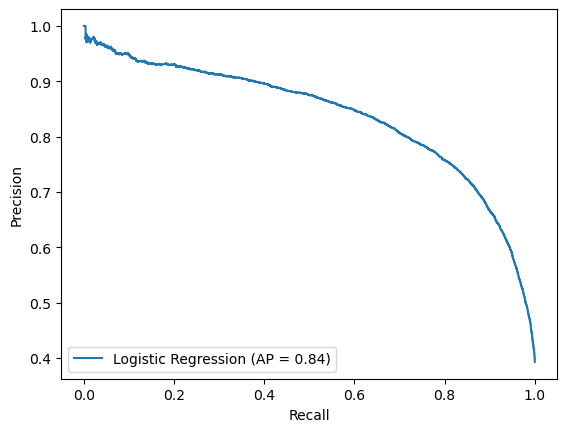

In [20]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

average_precision = average_precision_score(y_test, y_pred_proba, pos_label=1)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name='Logistic Regression')
pr_display.plot()


Both charts indicate the model's ability to discriminate between the two classes, where a straight line is as good as random selection, whereas a curve up to the top left (top right for precision-recall) corner is perfect discrimination. To quantify the model's ability to discriminate according to each plot, we take the area under each curve, where 0.5 is no ability and 1 is perfect ability. Specifically, the ROC curve shows false positives against true positives, and the reported ROC-AUC curve exceeds our reported accuracy, which is a good sign as to the robustness of our model's discriminatory ability.

The Precision-Recall chart is similar, but is more illuminating for unbalanced data sizes across classes, which was one of the concerns expressed above. And, indeed, we see that the area under the precision-recall curve is 0.84, less than that of the ROC curve. This indicates to us that to eek out more predictive capacity from the model in the future, we may need to use techniques to mitigate this unevenness. Even though the split is relatively minor, maybe 60% to 40%, because the feature pool is so large and sparse, the model seems to have a tendency toward predicting feminine names.

Discussion and Conclusion:

This classification task appeared simple at the outset, being a binary classification task with roughly balanced classes. The real challenge was deciding how to split the names up into numerical features which a regression could be fit to. Initially, I tried to use a half-dozen intuitive features, like length, vowel density, and first letter. However, training regressions to just these features, there was not enough information encoded to train a viable classifier. I got accuracy of ~60%, which is terrible considering you could get ~60% by always guessing feminine, since there were a bit more feminine names than masculine. (A larger problem than I anticipated.)

The major breakthrough was using n-gram encodings, which I was initially resistant to do because of how they ballooned the feature count. (~10,000 distinct n-grams) And, indeed, when I trained logistic regressions on the n-gram features, I saw signs of overfitting, such as a higher accuracy than F1-score. By applying a penalty to the magnitudes of coefficients, I was able to eliminate about three-fourths of these features from the model, resulting in a 10-point increase in precision, recall, and F1-score, but only a tiny increase in accuracy.

Breaking apart the model, we indeed saw features with high-magnitude coefficients which were associated with only a handful of names, indicating overfitting. This is disappointing, as it limits the interpretive potential of the model. It may be the case that name-gendering is just not a task which is feasible with a small number of features, since names are so diverse and contingent. The method we took here was motivated by our interest in drawing inferences from the model, but real-life applications of this classification problem will likely be predictive. In this case, when you have access to a large data set like this one of gender-labelled names, and you need to extrapolate a gender label to a novel name, a k-nearest neighbors approach with distance defined by n-grams will likely be a better choice. The boundary between masculine and feminine names in terms of n-gram components is complex, and not a clean planar divide.